In [ ]:
# !pip install SPARQLWrapper

In [4]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.models import Model
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Multiply, MaxPooling1D
from tensorflow.keras.layers import Input, Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout, Concatenate, Attention
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
import nltk
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from urllib.parse import quote
from tensorflow.keras.models import load_model
import requests
import json
import re
# from SPARQLWrapper import SPARQLWrapper, JSON

In [5]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [6]:
def preprocess_text(text):
    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalnum() and token not in stop_words]
    return " ".join(tokens)

In [ ]:
train_df = pd.read_csv('/Data/train_data.csv')
test_df=pd.read_csv('/Data/test_data.csv')
train_df['label'] = train_df['label'].map({'hate': 0, 'nothate': 1})
test_df['label'] = test_df['label'].map({'hate': 0, 'nothate': 1})
train_df['text'] = train_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_filepath = '/Models/DbpediaAttention/Dbpedia_Attention_Model.h5'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)



The below code snippet defines a function `get_topic` that retrieves DBpedia entities related to a given text using the DBpedia Spotlight API.

The function `get_topic` takes the following parameters:
- `text`: The input text for which DBpedia entities are to be retrieved.
- `confidence`: The confidence score threshold for DBpedia entity extraction (default: 0.5).
- `support`: The support threshold for DBpedia entity extraction (default: 20).

The function performs the following steps:
1. It defines the DBpedia Spotlight API URL as `spotlight_url` and sets the request headers to accept JSON responses.
2. It constructs the request parameters with the provided `text`, `confidence`, and `support` values.
3. It sends a GET request to the DBpedia Spotlight API with the specified URL, headers, and parameters.
4. If the response status code is 200 (indicating a successful request), it parses the response JSON data.
   - It retrieves the list of "Resources" from the JSON data.
   - It extracts the URIs of the resources into the `entities` list.
   - It returns the list of entity URIs.
5. If the response status code is not 200, it returns an empty list.
6. If any exception occurs during the request or parsing, it prints an error message and returns an empty list.




In [7]:
def get_topic(text, confidence=0.5, support=20):
    spotlight_url = "https://api.dbpedia-spotlight.org/en/annotate"
    headers = {'Accept': 'application/json'}
    params = {
        'text': text,
        'confidence': confidence,
        'support': support,
    }
    try:
        response = requests.get(spotlight_url, headers=headers, params=params)
        if response.status_code == 200:
            data = json.loads(response.text)
            resources = data.get("Resources", [])
            entities = [resource["@URI"] for resource in resources]
            return entities
        else:
            return []
    except Exception as e:
        print(f"Error retrieving DBpedia entities: {e}")
        return []

In [8]:
test_df=pd.read_csv('/Models/DbpediaAttention/test_data_topics.csv')
train_df=pd.read_csv('/Models/DbpediaAttention/train_data_topics.csv')
train_df = train_df.dropna(subset=['text'])
test_df = test_df.dropna(subset=['text'])

train_df['text'] = train_df['text'].astype(str)
test_df['text'] = test_df['text'].astype(str)

In [9]:
MAX_SEQ_LENGTH = 256 # Maximum length of input sequence
EMBEDDING_DIM = 50 # Dimensionality of word embeddings
FILTER_SIZES = [2, 3, 4] # Filter sizes for convolutional layers
NUM_FILTERS = 64 # Number of filters for each filter size
DROPOUT_RATE = 0.5 # Dropout rate for regularization
ATTENTION_UNITS = 128 # Number of units for attention layer
NUM_CLASSES = 1 # Number of output classes
LEARNING_RATE = 1e-3 # Learning rate for optimizer
BATCH_SIZE = 32 # Batch size for training



The below code snippet performs the following steps:

1. It defines the `GLOVE_FILE` variable with the path to a GloVe file ('/Models/glove.6B.50d.txt').
2. It initializes an empty dictionary `embeddings_index` to store word embeddings.
3. It opens the GloVe file using `open()` with UTF-8 encoding.
4. It iterates over each line in the file.
   - It splits each line into a list of values.
   - It extracts the word from the first value in the list.
   - It converts the remaining values into a NumPy array of float32 dtype, representing the word's embedding.
   - It adds the word and its embedding to the `embeddings_index` dictionary.
5. It initializes a `Tokenizer` object `tokenizer` with a limit of 5000 words.
6. It fits the tokenizer on the 'text' column of the `train_df` DataFrame.
7. It calculates the vocabulary size by adding 1 to the length of the tokenizer's word index.
8. It initializes an embedding matrix `embedding_matrix` of zeros with dimensions (vocab_size, EMBEDDING_DIM), where EMBEDDING_DIM represents the dimensionality of the word embeddings (50 in this case).
9. It iterates over each word and its corresponding index in the tokenizer's word index.
   - It retrieves the embedding vector for the word from the `embeddings_index` dictionary.
   - If the embedding vector exists, it assigns it to the corresponding row of the `embedding_matrix`.
10. The code assumes the existence of a pre-trained GloVe file and the `train_df` DataFrame.




In [10]:
GLOVE_FILE = '/Models/glove.6B.50d.txt'
embeddings_index = {}
with open(GLOVE_FILE, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_df['text'])
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector



The below code snippet performs the following steps:

1. It defines an `Embedding` layer `embedding_layer` with the following parameters:
   - `vocab_size`: The size of the vocabulary.
   - `EMBEDDING_DIM`: The dimensionality of the word embeddings.
   - `weights`: The pre-trained embedding matrix.
   - `input_length`: The length of input sequences.
   - `trainable`: Whether the embedding layer should be trainable or not. In this case, it is set to `False`.
2. It creates a list `topics` by concatenating the 'topics' column values from `train_df` and `test_df`.
3. It extracts unique topics from the `topics` list and assigns them to the `unique_topics` list.
4. It creates a dictionary `topic_index` that maps each unique topic to its index.
5. It extracts the 'topics' column values from `train_df` and assigns them to `train_topics`.
6. It initializes an empty list `train_topic_vectors`.
7. It iterates over each list of topics in `train_topics`.
   - It initializes a topic vector `topic_vector` as an array of zeros with a length equal to the number of topics in `topic_index`.
   - It iterates over each topic in the list of topics.
     - It sets the corresponding index in `topic_vector` to 1, indicating the presence of that topic.
   - It appends the `topic_vector` to the `train_topic_vectors` list.
8. It extracts the 'topics' column values from `test_df` and assigns them to `test_topics`.
9. It initializes an empty list `test_topic_vectors`.
10. It iterates over each list of topics in `test_topics`.
    - It initializes a topic vector `topic_vector` as an array of zeros with a length equal to the number of topics in `topic_index`.
    - It iterates over each topic in the list of topics.
      - It sets the corresponding index in `topic_vector` to 1, indicating the presence of that topic.
    - It appends the `topic_vector` to the `test_topic_vectors` list.



In [11]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            EMBEDDING_DIM,
                                            weights=[embedding_matrix],
                                            input_length=MAX_SEQ_LENGTH,
                                            trainable=False)

topics = train_df['topics'].tolist() + test_df['topics'].tolist()
unique_topics = list(set([item for sublist in topics for item in sublist]))
topic_index = {topic: i for i, topic in enumerate(unique_topics)}

train_topics = train_df['topics'].tolist()
train_topic_vectors = []
for topics in train_topics:
    topic_vector = np.zeros(len(topic_index))
    for topic in topics:
        topic_vector[topic_index[topic]] = 1
    train_topic_vectors.append(topic_vector)

test_topics = test_df['topics'].tolist()
test_topic_vectors = []
for topics in test_topics:
    topic_vector = np.zeros(len(topic_index))
    for topic in topics:
        topic_vector[topic_index[topic]] = 1
    test_topic_vectors.append(topic_vector)



The below code snippet performs the following steps:

1. It defines an `Input` layer `text_input` with the shape `(MAX_SEQ_LENGTH,)` and data type `'int32'`.
2. It defines an `Input` layer `topic_input` with the shape `(len(topic_index),)` and data type `'float32'`.
3. It applies the `embedding_layer` to the `text_input` tensor, producing an `embedded_text` tensor.
4. It initializes an empty list `conv_layers`.
5. It iterates over each `filter_size` in the `FILTER_SIZES` list.
   - It applies a `Conv1D` layer to the `embedded_text` tensor with parameters:
     - `NUM_FILTERS`: The number of filters.
     - `filter_size`: The size of the filters.
     - `activation`: The activation function, set to `'relu'`.
   - It applies a `GlobalMaxPooling1D` layer to the `conv_layer`, reducing the dimensionality.
   - It appends the resulting `pool_layer` to the `conv_layers` list.
6. It concatenates all the tensors in `conv_layers` along the channel axis, producing a merged tensor `merged_text`.




In [12]:
text_input = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32')
topic_input = tf.keras.layers.Input(shape=(len(topic_index),), dtype='float32')

embedded_text = embedding_layer(text_input)
conv_layers = []
for filter_size in FILTER_SIZES:
    conv_layer = tf.keras.layers.Conv1D(NUM_FILTERS,
                                        filter_size,
                                        activation='relu')(embedded_text)
    pool_layer = tf.keras.layers.GlobalMaxPooling1D()(conv_layer)
    conv_layers.append(pool_layer)
merged_text = tf.keras.layers.concatenate(conv_layers)


The below code snippet performs the following steps:

1. It applies a `Dense` layer to the `topic_input` tensor with parameters:
   - `ATTENTION_UNITS`: The number of units in the layer.
   - `activation`: The activation function, set to `'tanh'`.
   - The resulting tensor is assigned to `attention_layer`.
2. It applies another `Dense` layer to the `attention_layer` tensor with parameters:
   - `len(FILTER_SIZES)`: The number of filters, which represents the attention weights for each filter size.
   - `activation`: The activation function, set to `'softmax'`.
   - The resulting tensor is assigned to `attention_weights`.
3. It reshapes the `attention_weights` tensor to have shape `(len(FILTER_SIZES), 1)` using `Reshape`.
4. It performs element-wise multiplication between `merged_text` tensor and `attention_weights` tensor using `multiply`.
5. It applies a `Lambda` layer to the resulting tensor, which sums the values along the second-to-last axis using `tf.keras.backend.sum`.
6. It concatenates the `merged_text` tensor and the `topic_input` tensor along the channel axis using `concatenate`, producing `merged_inputs`.
7. It applies a `Dense` layer to the `merged_inputs` tensor with parameters:
   - `64`: The number of units in the layer.
   - `activation`: The activation function, set to `'relu'`.
   - The resulting tensor is assigned to `dense_layer`.
8. It applies a `Dropout` layer to the `dense_layer` tensor with a dropout rate of `DROPOUT_RATE`.
9. It applies another `Dense` layer to the `dropout_layer` tensor with parameters:
   - `NUM_CLASSES`: The number of classes in the output layer.
   - `activation`: The activation function, set to `'sigmoid'`.
   - The resulting tensor is assigned to `output_layer`.
10. It defines the model using `tf.keras.Model` with inputs `[text_input, topic_input]` and outputs `output_layer`.
11. It compiles the model using parameters:
    - `optimizer`: The optimizer, set to `'adam'`.
    - `loss`: The loss function, set to `'binary_crossentropy'`.
    - `metrics`: The evaluation metric, set to `['accuracy']`.





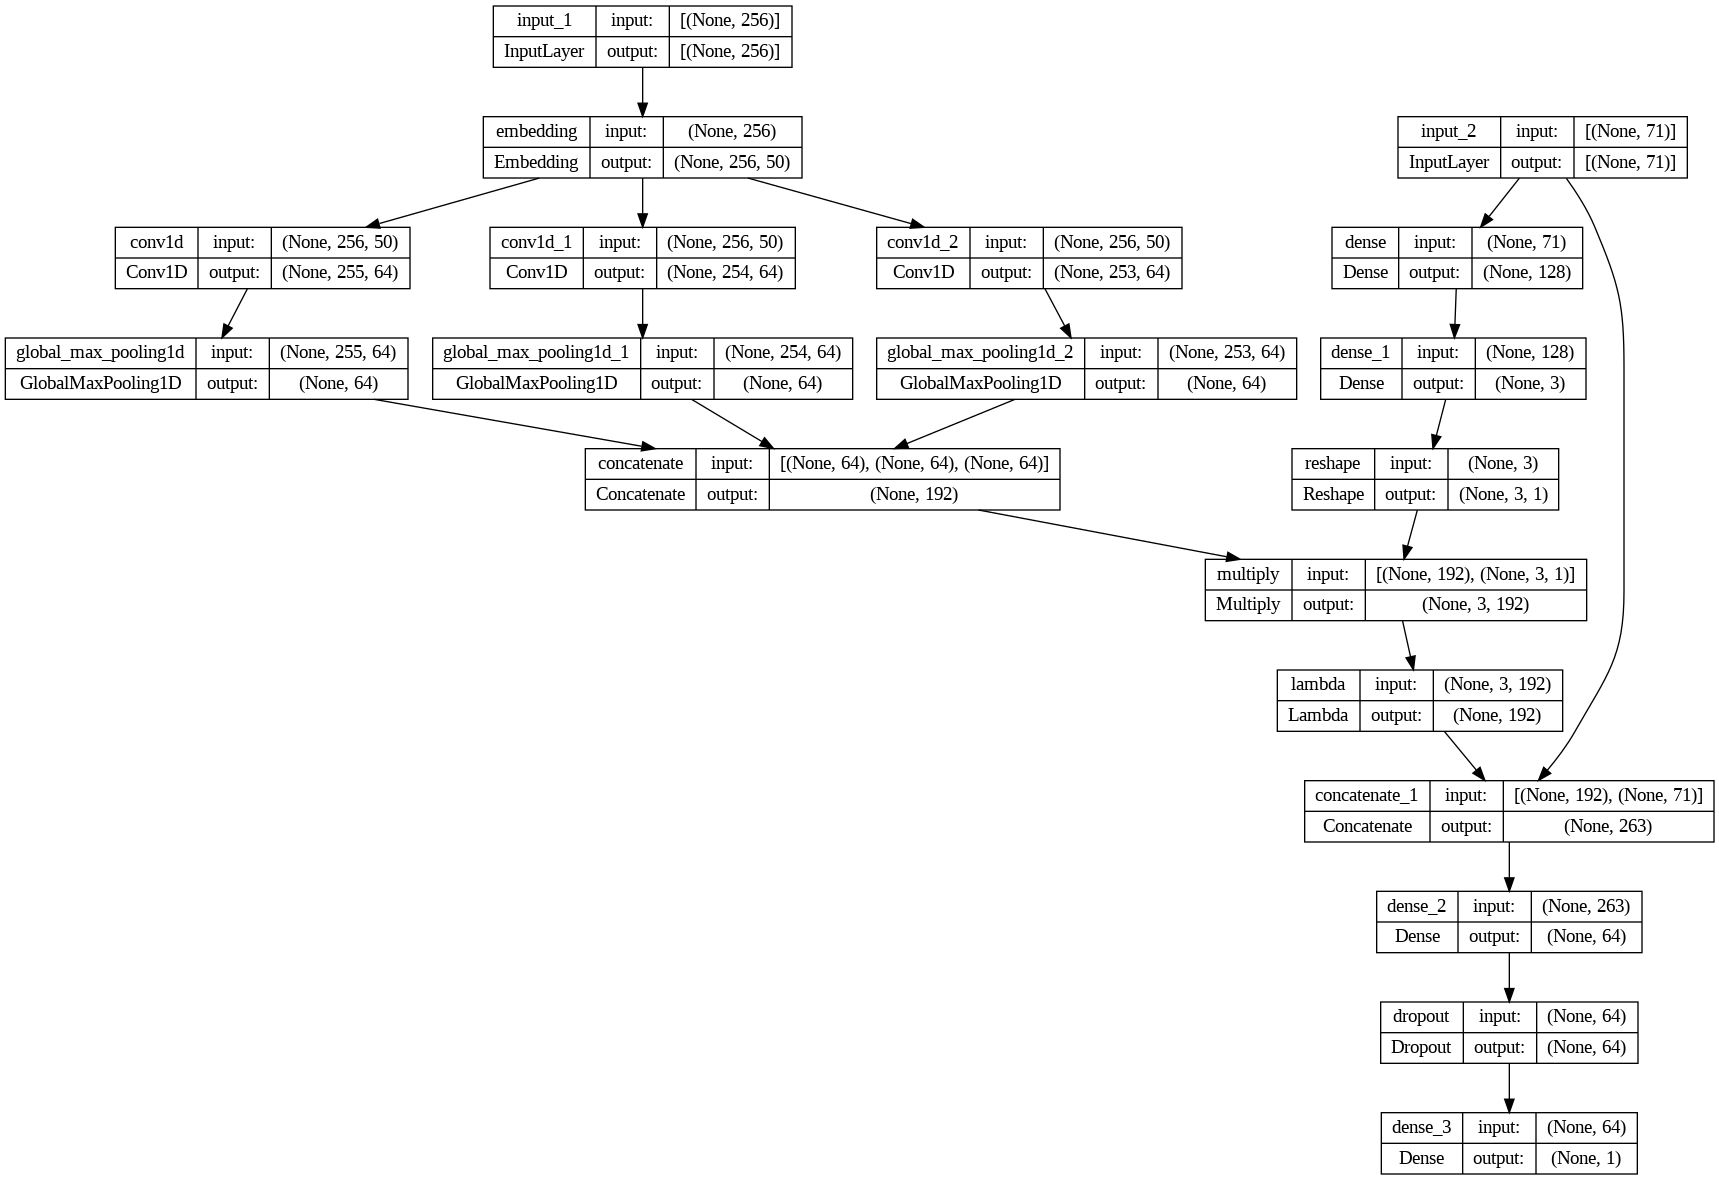

In [13]:
attention_layer = tf.keras.layers.Dense(ATTENTION_UNITS,activation='tanh')(topic_input)
attention_weights = tf.keras.layers.Dense(len(FILTER_SIZES), activation='softmax')(attention_layer)
attention_weights = tf.keras.layers.Reshape((len(FILTER_SIZES), 1))(attention_weights)
merged_text = tf.keras.layers.multiply([merged_text, attention_weights])
merged_text = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=-2))(merged_text)
merged_inputs = tf.keras.layers.concatenate([merged_text, topic_input])
dense_layer = tf.keras.layers.Dense(64, activation='relu')(merged_inputs)
dropout_layer = tf.keras.layers.Dropout(DROPOUT_RATE)(dense_layer)
output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='sigmoid')(dropout_layer)
model = tf.keras.Model(inputs=[text_input, topic_input],outputs=output_layer)

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
tf.keras.utils.plot_model(model, to_file='cnn_architecture.png', show_shapes=True, show_layer_names=True, rankdir='TB', dpi=96)

In [ ]:
train_topic_vectors=np.asarray(train_topic_vectors)
test_topic_vectors=np.asarray(test_topic_vectors)



The below code snippet performs the following steps:

1. It imports the `to_categorical` function from `keras.utils`.
2. It splits the training data into training and validation sets using `train_test_split`.
   - It assigns the 'text' column values of `train_df` to `X_train`.
   - It assigns the 'label' column values of `train_df` to `Y_train`.
   - It assigns the `train_topic_vectors` to `T_train`.
   - It assigns the 'text' and 'label' column values of the validation set to `X_val` and `Y_val`, respectively.
   - The test size is set to 0.1, and the random state is set to 42.
3. It initializes a `Tokenizer` object `tokenizer` with a limit of 5000 words.
4. It fits the tokenizer on the 'text' column values of `X_train`.
5. It converts the text sequences in `X_train` to sequences of integers using `texts_to_sequences`.
6. It pads the sequences in `X_train` with zeros or truncates them to a maximum length of `MAX_SEQ_LENGTH` using `pad_sequences`.
7. It converts `Y_train` and `Y_val` to numpy arrays using the `values` attribute.
8. It initializes another `Tokenizer` object `tokenizer` for the test data.
9. It fits the tokenizer on the 'text' column values of `test_df`.
10. It converts the text sequences in `test_df['text']` to sequences of integers using `texts_to_sequences`.
11. It pads the sequences in `X_test` with zeros or truncates them to a maximum length of `MAX_SEQ_LENGTH` using `pad_sequences`.
12. It assigns the 'label' column values of `test_df` to `Y_test`.
.


In [ ]:
from keras.utils import to_categorical

X_train, X_val, Y_train, Y_val, T_train, T_val = train_test_split(train_df['text'], train_df['label'], train_topic_vectors, test_size=0.1, random_state=42)

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=MAX_SEQ_LENGTH)

X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val, maxlen=MAX_SEQ_LENGTH)
Y_train = Y_train.values
Y_val = Y_val.values

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000)
tokenizer.fit_on_texts(test_df['text'])
X_test = tokenizer.texts_to_sequences(test_df['text'])
X_test = pad_sequences(X_test, maxlen=MAX_SEQ_LENGTH)

Y_test=test_df['label'].values

In [ ]:
Y_val

array([1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1]

In [ ]:
history = model.fit([X_train, T_train],
                    Y_train,
                    epochs=20,
                    batch_size=BATCH_SIZE,
                    validation_data=([X_val, T_val], Y_val),
                    callbacks=[checkpoint_callback])

Epoch 1/20
83/85 [============================>.] - ETA: 0s - loss: 0.6517 - accuracy: 0.6397
Epoch 1: val_accuracy improved from -inf to 0.68439, saving model to /content/drive/MyDrive/FYP-DATA-AND-RESOURCES/Models_and_data/DbpediaAttention/Dbpedia_Attention_Model.h5
85/85 [==============================] - 4s 17ms/step - loss: 0.6504 - accuracy: 0.6410 - val_loss: 0.5851 - val_accuracy: 0.6844
Epoch 2/20
78/85 [==========================>...] - ETA: 0s - loss: 0.5527 - accuracy: 0.7228
Epoch 2: val_accuracy improved from 0.68439 to 0.73090, saving model to /content/drive/MyDrive/FYP-DATA-AND-RESOURCES/Models_and_data/DbpediaAttention/Dbpedia_Attention_Model.h5
85/85 [==============================] - 1s 7ms/step - loss: 0.5513 - accuracy: 0.7243 - val_loss: 0.5459 - val_accuracy: 0.7309
Epoch 3/20
79/85 [==========================>...] - ETA: 0s - loss: 0.4646 - accuracy: 0.7781
Epoch 3: val_accuracy improved from 0.73090 to 0.74751, saving model to /content/drive/MyDrive/FYP-DATA-AN

In [ ]:
from tensorflow.keras.models import load_model
saved_model=load_model('/Models/DbpediaAttention/Dbpedia_Attention_Model.h5')

In [ ]:
len(train_topic_vectors)

3003

In [ ]:
pred=saved_model.predict([X_test,test_topic_vectors])
loss,acc=saved_model.evaluate([X_test,test_topic_vectors],test_df['label'],batch_size=32)

for i,x in enumerate(pred):#"hate":0,"nothate":1
  if x >= 0.5:
    pred[i] = 1
  else:
    pred[i] = 0
cm = confusion_matrix(test_df['label'],pred)
print(cm)
cr = classification_report(test_df['label'],pred)
print(cr)

11/11 [==============================] - 0s 3ms/step - loss: 1.4756 - accuracy: 0.6497
[[ 99  90]
 [ 27 118]]
              precision    recall  f1-score   support

           0       0.79      0.52      0.63       189
           1       0.57      0.81      0.67       145

    accuracy                           0.65       334
   macro avg       0.68      0.67      0.65       334
weighted avg       0.69      0.65      0.65       334

